# Do Hosted LLMs Always Become Non-deterministic Given Enough Runs?

Author: Breck Baldwin, breckbaldwin@gmail.com
July 4, 2025
w;AI (GPT4o)

Location of this notebook: https://github.com/breckbaldwin/llm-stability/blob/main/experiments/stochastic_non_determinism/analysis.ipynb

This work is a continuation of the paper at: [Non-Determinism of “Deterministic” LLM Settings](https://arxiv.org/pdf/2408.04667). I'll try and make this notebook stand alone but I am extending that work conceptually and the code base so it is a place for more background. 

## Introduction

I have noticed that we see more non-determinism as the count of runs goes up. For the V1 paper we ran 5 runs and for V2 and V3 papers we went with 10 runs for the most part. An anonymous reviewer wanted to know the rate of non-determinism over repeat runs which I thought was an excellent idea. 

This notebook explores whether the non-determinism is just a matter of time for any given question or does the LLM settle on a deterministic set of rubrics across the benchmark. I also sneak in some more modern models from those used in the work which started in summer 2024. 

TL;DR It looks like there is a stable subset of rubrics for the tried benchmarks where subsequent runs do not introduce further non-determinism. More modern models, Gemini 2.5 pro and DeepSeek R1, also exhibit non-determinism at an even greater rate than older models like Llama 70b, Gemini 1.5 pro and GPT-3.5.

## Experiments

I made some minor changes to the `run_experiment.py` script to continue to reprocess rubrics from the benchmark if the LLMs reponses were deterministic, i.e., if on run 2 the rubric 23 gave a different response at the string level then the rubric was not included in the next run. The iterations were stopped if either the last 4 runs did not discover any new non-determinism or all rubrics had been shown to be non-determinsitic. 

![Flow Diagram of Experiment Execution](./img/flow.png?v=1)

For you math heads in need of gratuitous formulaes (thank you ChatGPT for the diagram and LaTex) :

$$
\begin{aligned}
&\text{Let } R \text{ be the full set of rubrics} \\
&D_i = \text{Rubrics found non-deterministic at run } i \\
&\Delta_i = D_i \setminus \bigcup_{j=1}^{i-1} D_j \quad \text{(newly discovered)} \\
&\text{Stop at run } k \text{ if:} \\
&\quad \bigcup_{i=1}^{k} D_i = R \quad \textbf{or} \quad \Delta_{k-3} = \Delta_{k-2} = \Delta_{k-1} = \Delta_{k} = \emptyset
\end{aligned}
$$

The command to run with some output is below, the `-n` parameter controls how many repeat runs are done, setting to `-1` invokes the termination conditions above:

```
llm-stability % python run_experiment.py -m models/mixtral-8x7b.py -mc '{"temperature":0.0, "seed": 12, "top_p_k": 0.0}' -t tasks/college_mathematics.py -tc '{"prompt_type": "v2", "shots": 0}' -n -1 
No existing file, running mixtral-8x7b-0.0-college_mathematics-0
Model loaded
Limiting test to first None rubrics
Data loaded
Making output directories if necessary local_runs/mixtral-8x7b-0.0-college_mathematics-0_2025-07-04_05-41-38
File system ready for run
Running 0
100%|██████████████████████████████| 100/100 [15:40<00:00,  9.41s/it]
*** Wrote local_runs/mixtral-8x7b-0.0-college_mathematics-0_2025-07-04_05-41-38/mixtral-8x7b-0.0-college_mathematics-0-0.csv [0]
Running 1
  0%|                                        | 0/100 [00:00<?, ?it/s]Non equivalent response 0
  1%|▎                               | 1/100 [00:09<16:01,  9.71s/it]Non equivalent response 1
  2%|▋                               | 2/100 [00:15<11:44,  7.19s/it]Non equivalent response 2
  3%|▉                               | 3/100 [00:18<08:48,  5.45s/it]Non equivalent response 3
  4%|█▎                              | 4/100 [00:25<09:59,  6.25s/it]Non equivalent response 4

<..elided..>

Non equivalent response 76
 93%|████████████████████████████▊  | 93/100 [01:18<00:03,  1.97it/s]Non equivalent response 98
100%|██████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]
*** Wrote local_runs/mixtral-8x7b-0.0-college_mathematics-0_2025-07-04_05-41-38/mixtral-8x7b-0.0-college_mathematics-0-2.csv [0, 81, 90]
Running 3
  6%|█▉                              | 6/100 [00:05<01:29,  1.05it/s]Non equivalent response 10
 54%|████████████████▋              | 54/100 [00:20<00:15,  2.97it/s]Non equivalent response 55
 56%|█████████████████▎         

<..ellided..>

Running 8
100%|██████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]
*** Wrote local_runs/mixtral-8x7b-0.0-college_mathematics-0_2025-07-04_05-41-38/mixtral-8x7b-0.0-college_mathematics-0-8.csv [0, 81, 90, 93, 94, 97, 97, 97, 97]
No non-determinism observed for past 4 runs, stopping
````
Note that the penultimate line lists the counts of non-deterministic rubrics found so far and the termination condition. 

Results are copied and compressed to the `experiments/stochastic_non_determinism/runs.tgz`.

## Analyzing runs

It will be interesting to try and characterize a data generating process for the observed non-determinism. 

In [19]:
import glob
import pandas as pd
import tarfile
import os
import warnings
import ast
import json
import re
import importlib
import sys

sys.path.append(os.path.join(os.getcwd(),"..", ".."))

warnings.simplefilter("error", FutureWarning)

# Extract runs.tgz to current directory
if not os.path.exists('runs'):
    with tarfile.open('runs.tgz', 'r:gz') as tar:
        tar.extractall()

experiments = glob.glob('runs/*/*.csv')
data_df = pd.DataFrame()
for exp_run in experiments:
    exp_run_df = pd.read_csv(exp_run)
    print(exp_run)
    data_df = pd.concat([data_df, exp_run_df])

data_df['task_config'] = data_df['task_config'].apply(json.loads)
data_df['model_config'] = data_df['model_config'].apply(json.loads)


def add_label(row):
   model_config = row['model_config']
   prefix_val = model_config.get('prefix', '-1')
   match = re.search(r'[-\d]+', prefix_val)
   if not match:
       print(prefix_val)
   return row['model']
#   return row['task'] + '/' + row['model']
#   return row['task'] + '/' + row['model'] + ' ' + str(row['model_config']['top_p_k'])
#   return row['task'] + '/' + row['model'] + ' ' + match.group(0)

data_df['task/model'] = data_df.apply(lambda x: add_label(x), axis=1)
    
filter = 'college_mathematics'
#filter = 'ruin_names'
#filter = 'navigate'

display_df = data_df[data_df['task'] == filter].copy()
#display_df = display_df[~display_df['model'].str.contains('llama3-8b')]

for model_task in display_df['task/model'].unique():
    last_run = display_df[display_df['task/model'] == model_task]['run'].max()
    determinism_counts = []
    for i in range(0, last_run + 1):
       determinism_counts.append(len(display_df[(display_df['run'] == i)
                                 & (display_df['task/model'] ==  model_task)].index))
    print(model_task, determinism_counts)


def score(row, task_module):
    try:
        parsed_answer = task_module.answer_fn(row, row['task_config'])
        if parsed_answer is None:
            return False
    except LookupError as e:
        return False
    return task_module.correct_fn(row, row['task_config'])
#
for task_name in display_df['task'].unique():
    task_module = importlib.import_module(f'tasks.{task_name}')
    display_df['correct'] = display_df.apply(lambda x: score(x, task_module), axis=1)

display(display_df)


runs/deepseek_R1_0528-0.0-college_mathematics-0_2025-07-03_17-24-25/deepseek_R1_0528-0.0-college_mathematics-0-1.csv
runs/deepseek_R1_0528-0.0-college_mathematics-0_2025-07-03_17-24-25/deepseek_R1_0528-0.0-college_mathematics-0-0.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-9.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-8.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-11.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-10.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-12.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-13.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-6.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25-27/gemini_15_pro-0.0-navigate-0-7.csv
runs/gemini_15_pro-0.0-navigate-0_2025-07-04_03-25

,Unnamed: 0,model,model_config,task,task_config,rubric,rubric_id,question,modified_questions,gt,prompt,response,logprobs,date,run,task/model,correct
0,0,deepseek_R1_0528,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""Let k be the number of real solutio...",0,Let k be the number of real solutions of the e...,Let k be the number of real solutions of the e...,(B),"[{""role"": ""user"", ""content"": ""Let k be the num...",<think>\nI need to solve this problem. It asks...,[],2025-07-03_17-24-25,0,deepseek_R1_0528,False
1,1,deepseek_R1_0528,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""Up to isomorphism, how many additiv...",1,"Up to isomorphism, how many additive abelian g...","Up to isomorphism, how many additive abelian g...",(D),"[{""role"": ""user"", ""content"": ""Up to isomorphis...",<think>\nI need to find how many additive abel...,[],2025-07-03_17-24-25,0,deepseek_R1_0528,False
2,2,deepseek_R1_0528,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""Suppose P is the set of polynomials...",2,Suppose P is the set of polynomials with coeff...,Suppose P is the set of polynomials with coeff...,(D),"[{""role"": ""user"", ""content"": ""Suppose P is the...",<think>\nThe problem states that P is the set ...,[],2025-07-03_17-24-25,0,deepseek_R1_0528,False
3,3,deepseek_R1_0528,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""The shortest distance from the curv...",3,The shortest distance from the curve xy = 8 to...,The shortest distance from the curve xy = 8 to...,(A),"[{""role"": ""user"", ""content"": ""The shortest dis...",<think>\nI need to find the shortest distance ...,[],2025-07-03_17-24-25,0,deepseek_R1_0528,False
4,4,deepseek_R1_0528,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""There are 25 suitcases, 5 of which ...",4,"There are 25 suitcases, 5 of which are damaged...","There are 25 suitcases, 5 of which are damaged...",(C),"[{""role"": ""user"", ""content"": ""There are 25 sui...",<think>\nI have this probability problem. Ther...,[],2025-07-03_17-24-25,0,deepseek_R1_0528,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,Llama-32-3B-Instruct-Q3_K_XL,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""If U and V are 3-dimensional subspa...",95,"If U and V are 3-dimensional subspaces of R^5,...","If U and V are 3-dimensional subspaces of R^5,...",(D),"[{""role"": ""user"", ""content"": ""If U and V are 3...",## Step 1: Recall the basic properties of subs...,[],2025-07-12_21-31-34,0,Llama-32-3B-Instruct-Q3_K_XL,False
86,86,Llama-32-3B-Instruct-Q3_K_XL,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""Let S be the subset of R^2 consisti...",96,Let S be the subset of R^2 consisting of all p...,Let S be the subset of R^2 consisting of all p...,(C),"[{""role"": ""user"", ""content"": ""Let S be the sub...",## Step 1: Understand the definition of S\nS i...,[],2025-07-12_21-31-34,0,Llama-32-3B-Instruct-Q3_K_XL,False
87,87,Llama-32-3B-Instruct-Q3_K_XL,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_type': 'v2', 'shots': 0}","{""input"": ""Which of the following circles has ...",97,Which of the following circles has the greates...,Which of the following circles has the greates...,(C),"[{""role"": ""user"", ""content"": ""Which of the fol...",## Step 1: Understand the problem\nWe are give...,[],2025-07-12_21-31-34,0,Llama-32-3B-Instruct-Q3_K_XL,False
88,88,Llama-32-3B-Instruct-Q3_K_XL,"{'temperature': 0.0, 'seed': 12, 'top_p_k': 0.0}",college_mathematics,"{'prompt_ty

## Results

Below I report raw counts over iterations and then do some graphing. 



Above are counts with the remaining deterministic rubrics counted, remember that the algorith stops running when either there are 4 equivalent counts or no more rubrics are left, the only example of the latter is `college_mathematics/deepseek_R1_0528`. The same information is graphed below:

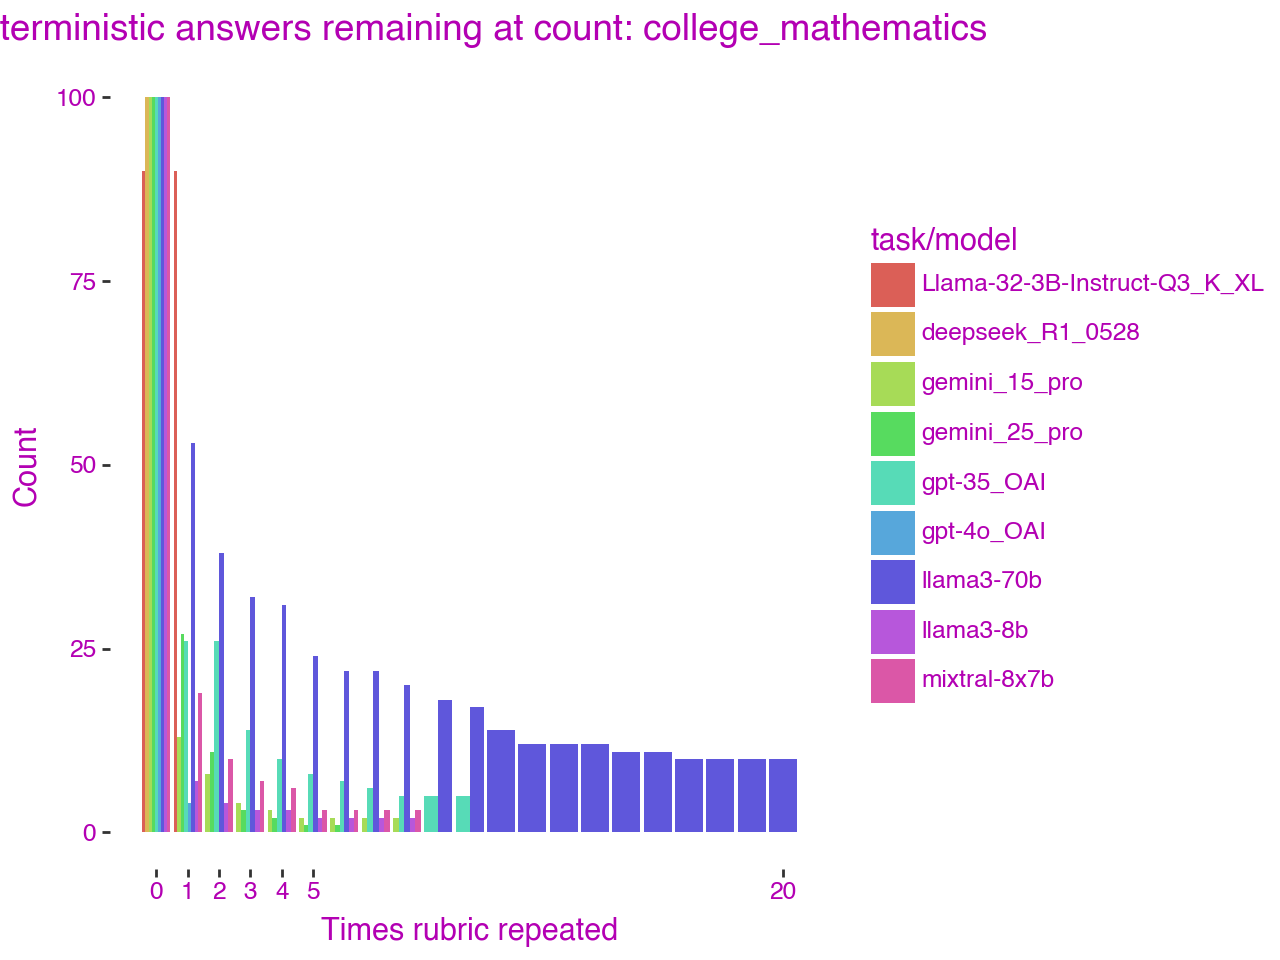

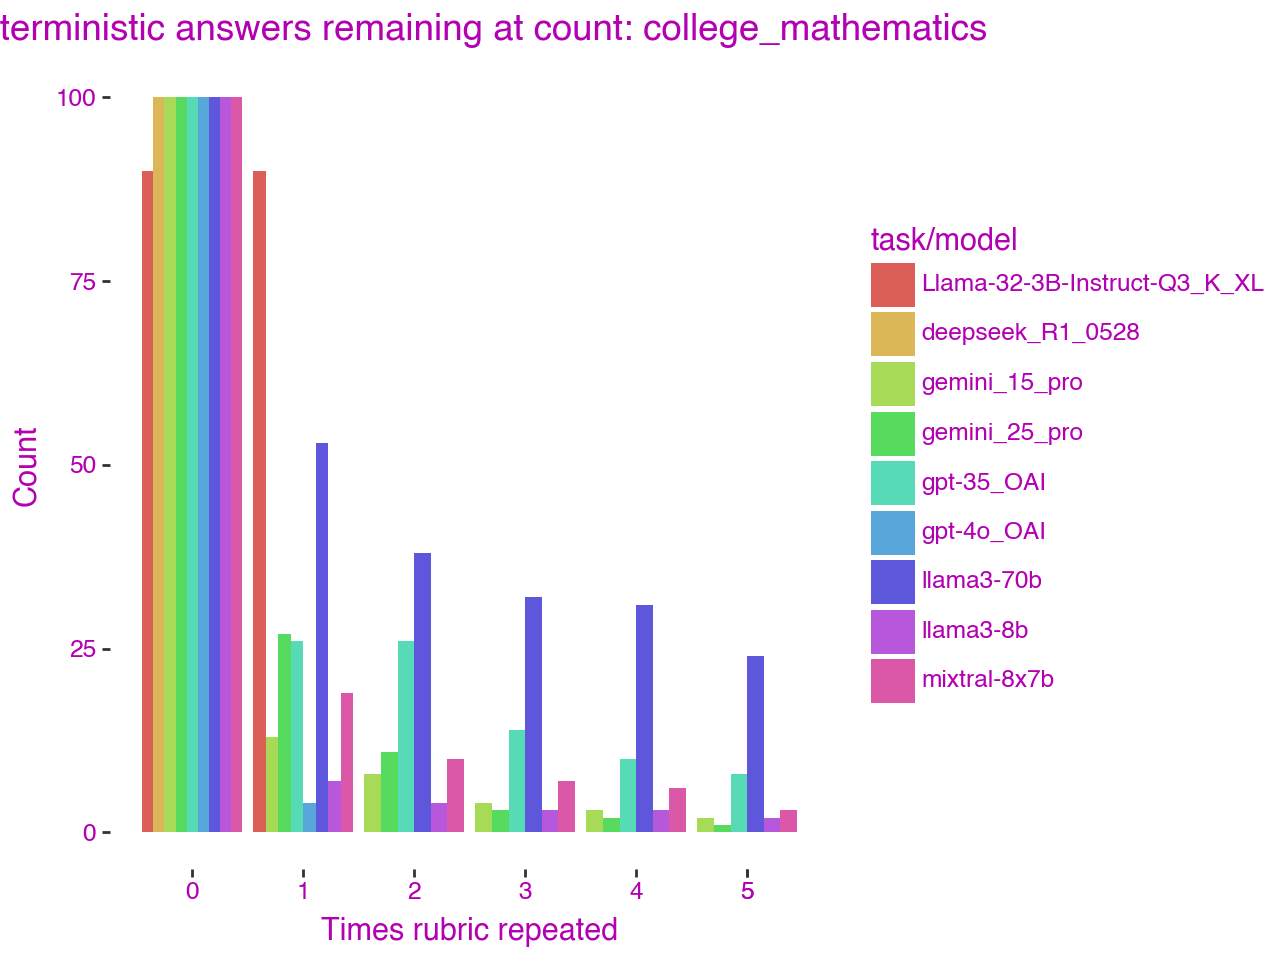

In [ ]:
import plotnine as p9

def plot_counts(display_df):
     task = display_df['task'].unique()
     if len(task) > 1:
         raise AttributeError(f"more than one task {task}, cannot graph")
     color="#b300b3"
     breaks = [0, 1, 2, 3, 4, 5, display_df['run'].unique().max()]
     return (
     p9.ggplot(display_df, p9.aes(x='run', fill='task/model')) +
     p9.geom_bar(position=p9.position_dodge(width=0.9)) +
     p9.scale_x_continuous(breaks=breaks) +
     p9.labs(title=f'Deterministic answers remaining: {task[0]}',
          x='Times rubric repeated',
          y='Count') +
     p9.theme(axis_text_x=p9.element_text(),
               text=p9.element_text(color=color),
               axis_text=p9.element_text(color=color),
               plot_background=p9.element_rect(fill='none'),
               panel_background=p9.element_rect(fill='none'),
               panel_grid_minor_x=p9.element_blank(),
               panel_grid_minor_y=p9.element_blank(),
               panel_grid_major_x=p9.element_blank(),
               panel_grid_major_y=p9.element_blank()
               )
     )

display_df['run'] = pd.to_numeric(display_df['run'], errors='coerce')
#display(display_df)

display(plot_counts(display_df))

focused_display_df = display_df[display_df['run'] < 6]

display(plot_counts(focused_display_df))


,task/model,run,correct %
51,college_mathematics/llama3-8b -1,0,0.420000
52,college_mathematics/llama3-8b -1,1,0.428571
53,college_mathematics/llama3-8b -1,2,0.500000
54,college_mathematics/llama3-8b -1,3,0.666667
55,college_mathematics/llama3-8b -1,4,0.666667
...,...,...,...
136,college_mathematics/llama3-8b 50,4,0.363636
137,college_mathematics/llama3-8b 50,5,0.375000
138,college_mathematics/llama3-8b 50,6,0.375000
139,college_mathematics/llama3-8b 50,7,0.375000


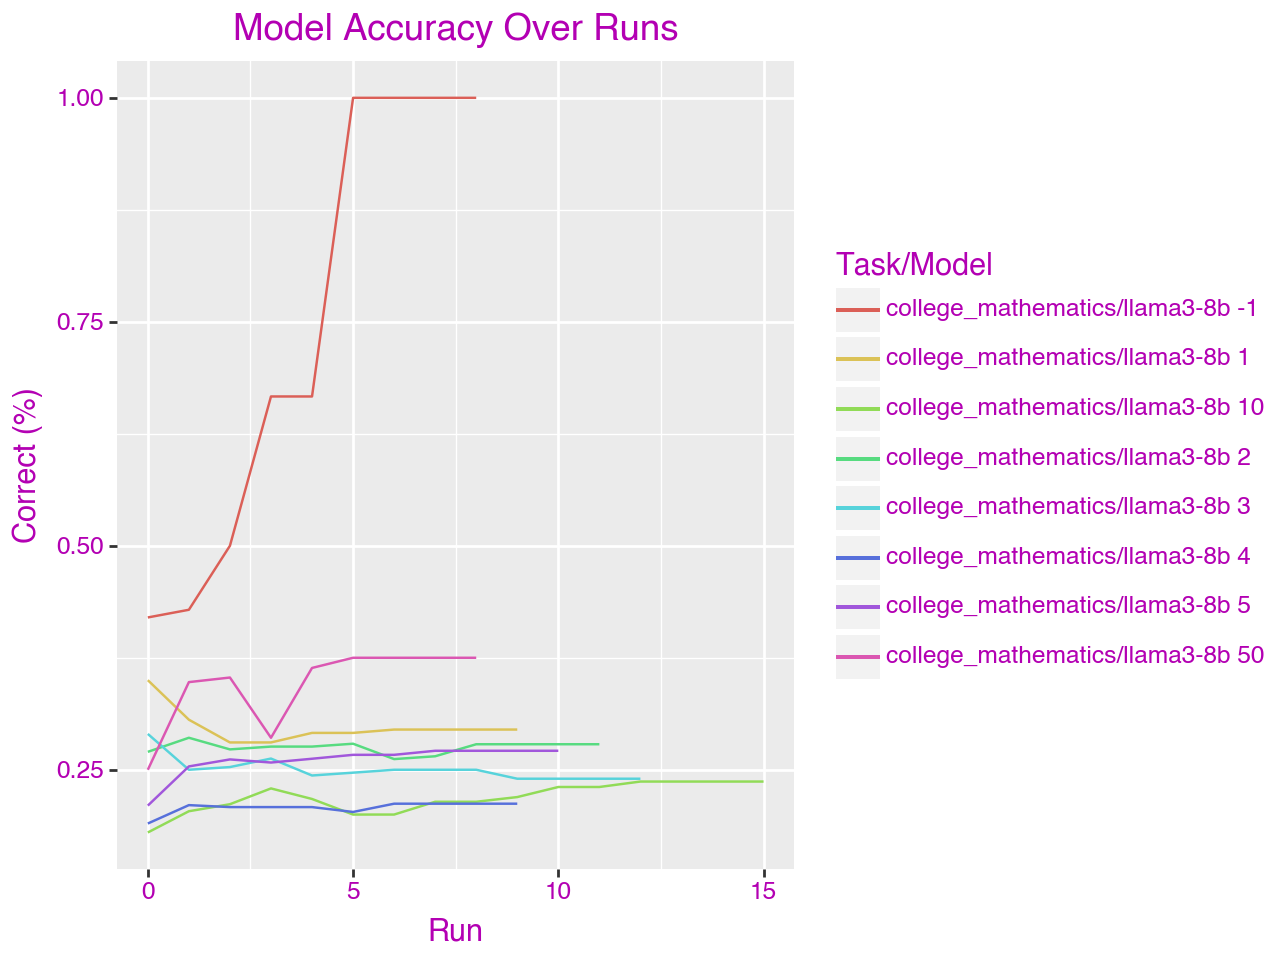

In [95]:
result_df = (
    display_df
    .groupby(['task/model', 'run'])['correct']
    .mean()
    .reset_index()
    .rename(columns={'correct': 'correct %'})
)

result_df = result_df[result_df['task/model'].str.contains('llama3-8b')]

display(result_df)

color="#b300b3"
plot = (
    p9.ggplot(result_df, p9.aes(x='run', y='correct %', color='task/model'))
    + p9.geom_line()
    + p9.labs(
        title='Model Accuracy Over Runs',
        x='Run',
        y='Correct (%)',
        color='Task/Model'
    )
    + p9.theme(
            axis_text_x=p9.element_text(),
            text=p9.element_text(color=color),
            axis_text=p9.element_text(color=color),
        ) 
)

display(plot)




## Observations

Above we see the counts per run of remaining deterministic output until termination above and for the first 5 repeat runs below. Plotnine, a ggplot2 clone from R, increases the width of the bar char if there is no data which may be confusing until one knows that. 

We have 100 rubrics in college math from the benchmark out of [MMLU](https://huggingface.co/datasets/cais/mmlu) and we can see they all get processed on run 0--then the culling begins. All non-GPT models are hosted by [together.ai](https://www.together.ai/), GPT models are hosted by OpenAI. 

Briefly I notice for round 1:

1. DeepSeek R1 is so non-determnistic that no rubrics were deterministic on the first repeated run as evidenced by the absence of any of it's color on round 1. 
2. The next runner up on non-determinism is gpt-4o_OAI with, upon examination of `gpt-4o_OAI-0.0-college_mathematics-0-1.csv` we see 4 suriving rubrics.  Next again we see `gemini_15_pro` with having 13 rubrics reminaining deterministic on run 1.
3. The most deterministic model overall is `llama3-70b` with 52 deterministic outcomes on round 1.

The determinism sets to a fixed point which indicates to me that either I am getting cache hits or there is something special about the rubrics that remain stable for 4 runs. All runs for a task/model tend to take less than 6 hours, often much less. [Veeery interesting](https://www.youtube.com/watch?v=baeI8KXU8ZA)

/Users/bb/git/S3rd/research/llm-stability/venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Users/bb/git/S3rd/research/llm-stability/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


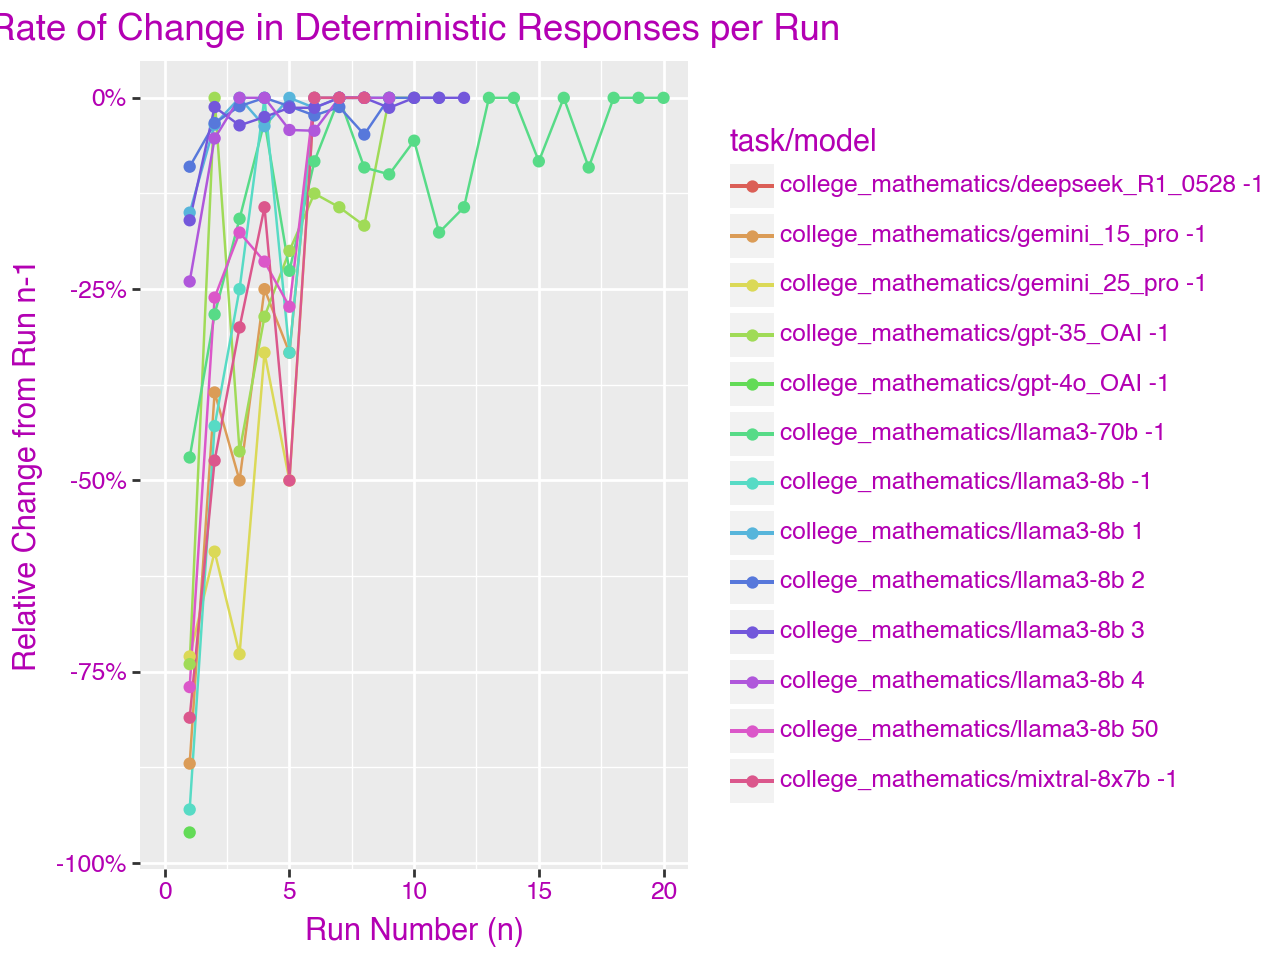

/Users/bb/git/S3rd/research/llm-stability/venv/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Users/bb/git/S3rd/research/llm-stability/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


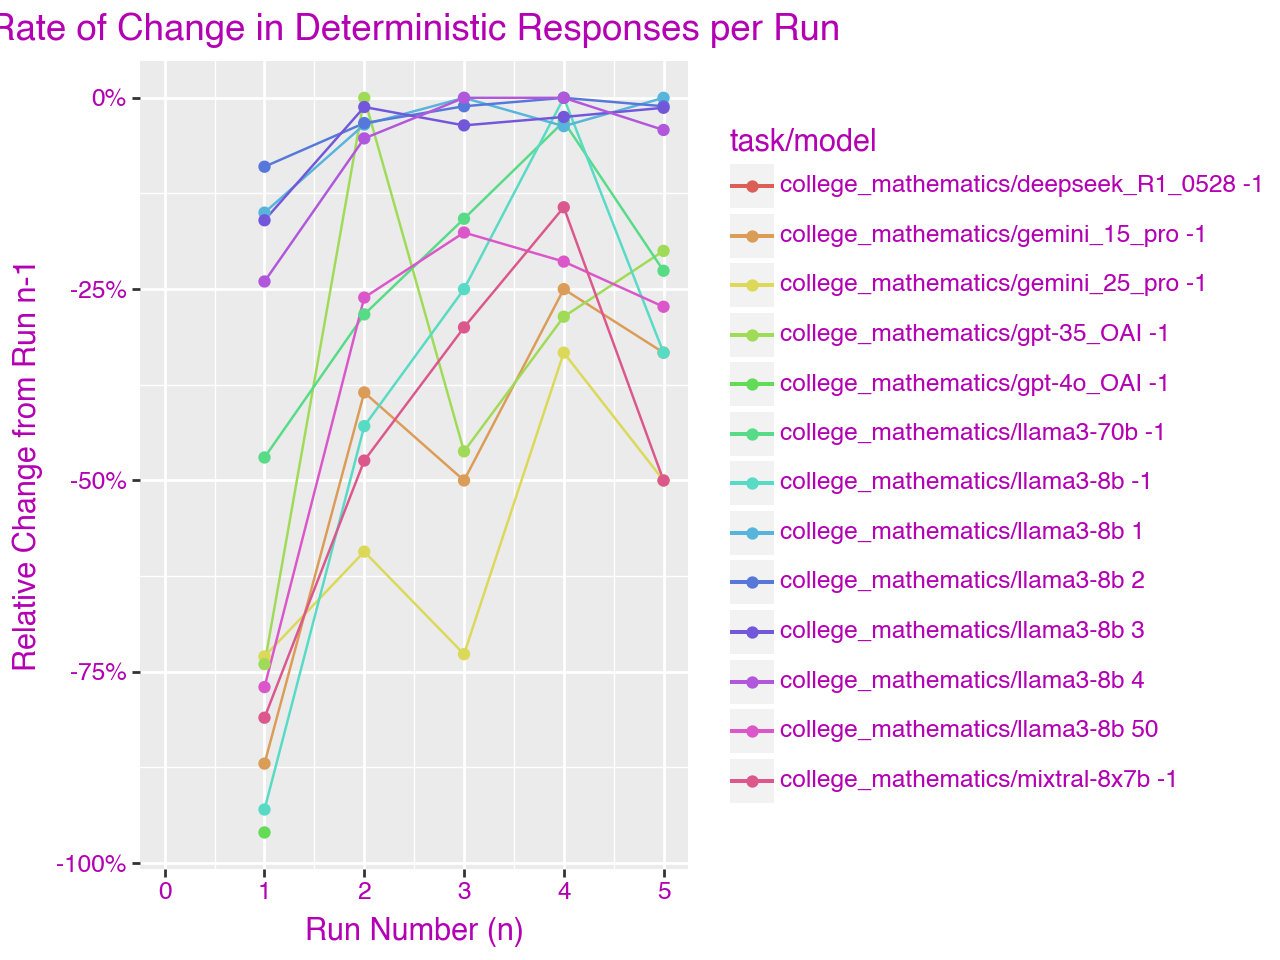

In [ ]:
import pandas as pd
import plotnine as p9

# Step 1: Count rows per (task/model, run)
grouped = (
    display_df.groupby(['task/model', 'run'])
      .size()
      .reset_index(name='count')
)

# Step 2: Compute rate of change per task/model
grouped['delta_rate'] = (
    grouped.groupby('task/model')['count']
           .pct_change()
)

# Optional: round for clarity
grouped['delta_rate'] = grouped['delta_rate'].round(3)


def plot_rates(grouped):

    color="#b300b3"

    # Step 3: Plot
    return (
        p9.ggplot(grouped, p9.aes(x='run', y='delta_rate', color='task/model')) +
        p9.geom_line() +
        p9.geom_point() +
        p9.labs(
            title='Rate of Change in Deterministic Responses per Run',
            x='Run Number (n)',
            y='Relative Change from Run n-1'
        ) +
        p9.theme(
            axis_text_x=p9.element_text(),
            text=p9.element_text(color=color),
            axis_text=p9.element_text(color=color),
        ) +
        p9.scale_y_continuous(labels=lambda l: [f'{x:.0%}' for x in l])
    )

display(plot_rates(grouped))

#display(grouped)
display(plot_rates(grouped[grouped['run'] < 6]))


### 📊 Figure: Relative Change in Deterministic Responses per Run by Task/Model

The above figure shows the **relative rate of change** (a discrete derivative) in the number of deterministic LLM responses across repeated runs, grouped by each `task/model` pair. A deterministic response is one that is identical to a previous run for the same prompt.

For each run \( n \), we compute:

$$
\Delta_r(n) = \frac{C_n - C_{n-1}}{C_{n-1}}
$$

Where:

- $ \Delta_r(n) $ is the **relative rate of change** (delta rate) at run $ n $
- $C_n $ is the count of deterministic responses at run $ n $
- $ C_{n-1} $ is the count from the previous run

This value captures how quickly a model stabilizes in its outputs for a given task:

- Values near **zero** indicate stability  
- Large **negative** values indicate increasing non-determinism

w:AI(GPT4o)


### Any qualities about the questions/answers that might contribute to determinism? 

Hypotheses about why we are seeing a 'fixed point' in determinism include:

1. Cacheing of some sort
2. Token length of question and/or answer
3. Difficulty of question, i.e. do right answers tend to be more/less determnistic?



#### Caching

#### Token length

Count the words as a proxy for the tokens and show distribution of tokens at each run.

In [45]:
import pandas as pd
import tiktoken
from transformers import AutoTokenizer

# Function to choose tokenizer based on model name
def get_tokenizer(model_name):
    if 'gpt-35' in model_name or 'gpt-4o' in model_name:
        try:
            return tiktoken.encoding_for_model(model_name)
        except KeyError:
            return tiktoken.get_encoding("cl100k_base")
    else:
        # Fallback tokenizer for unsupported or private models
        try:
            return AutoTokenizer.from_pretrained(model_name, use_fast=True)
        except Exception as e:
            print(f"Warning: Failed to load tokenizer for {model_name}, using fallback. Error: {e}")
            return AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)


# Cache tokenizers to avoid re-loading for repeated models
tokenizer_cache = {}

def tokenize_length(text, model_name):
    if model_name not in tokenizer_cache:
        tokenizer_cache[model_name] = get_tokenizer(model_name)
    
    tokenizer = tokenizer_cache[model_name]

    # tiktoken vs HF interface difference
    if isinstance(tokenizer, tiktoken.Encoding):
        return len(tokenizer.encode(text))
    else:
        return len(tokenizer.encode(text, add_special_tokens=False))

# Apply to dataframe
display_df['question token length'] = display_df.apply(
    lambda row: tokenize_length(row['question'], row['model']),
    axis=1
)

display_df['response token length'] = display_df.apply(
    lambda row: tokenize_length(row['response'], row['model']),
    axis=1
)


If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingf

Token indices sequence length is longer than the specified maximum sequence length for this model (2086 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1107 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [48]:
import pandas as pd
import numpy as np

models = []
runs = []
values = []
value_types = []

for model_task in display_df['task/model'].unique():
    if 'llama3-8b' not in model_task:
        continue
    last_run = display_df[display_df['task/model'] == model_task]['run'].max()
    determinism_counts_question = []
    determinism_counts_response = []
    for i in range(0, last_run + 1):
       #how many rows at run i for task/model?
        task_model_run_df = display_df[(display_df['run'] == i) 
                         & (display_df['task/model'] ==  model_task)]
        count = len(task_model_run_df.index)
        min = task_model_run_df['question token length'].min()
        max = task_model_run_df['question token length'].max()
        mean = np.mean(task_model_run_df['question token length'])

        determinism_counts.append([count, int(min), float(mean), int(max)])
        determinism_counts_response.append(
                       [count, 
                        int(task_model_run_df['response token length'].min()),
                        float(task_model_run_df['response token length'].mean()),
                        int(task_model_run_df['response token length'].max())])
        for q_or_a in ['response']:
            values_key = f'{q_or_a} token length'
            type_name = f'{q_or_a[0].upper()}'
            
            models.append(model_task)
            runs.append(i)
            values.append(task_model_run_df[values_key].min())
            value_types.append(f'min {type_name}')
            models.append(model_task)
            runs.append(i)
            values.append(task_model_run_df[values_key].mean())
            value_types.append(f'mean {type_name}')
            models.append(model_task)
            runs.append(i)
            values.append(task_model_run_df[values_key].max())
            value_types.append(f'max {type_name}')
    len_df = pd.DataFrame({'model': models, 'run': runs, 'value': values, 'value_type': value_types})
    print(model_task, determinism_counts_response)

college_mathematics/llama3-8b -1 [[100, 70, 695.13, 2325], [7, 70, 202.28571428571428, 376], [4, 70, 194.0, 376], [3, 70, 133.33333333333334, 240], [3, 70, 133.33333333333334, 240], [2, 70, 80.0, 90], [2, 70, 80.0, 90], [2, 70, 80.0, 90], [2, 70, 80.0, 90]]
college_mathematics/llama3-8b 4 [[100, 2, 131.82, 2044], [76, 2, 16.026315789473685, 155], [72, 2, 13.194444444444445, 104], [72, 2, 13.194444444444445, 104], [72, 2, 13.194444444444445, 104], [69, 2, 11.304347826086957, 100], [66, 2, 9.121212121212121, 29], [66, 2, 9.121212121212121, 29], [66, 2, 9.121212121212121, 29], [66, 2, 9.121212121212121, 29]]
college_mathematics/llama3-8b 3 [[100, 2, 38.59, 1107], [84, 2, 9.333333333333334, 84], [83, 2, 9.132530120481928, 84], [80, 2, 9.0375, 84], [78, 2, 8.448717948717949, 84], [77, 2, 8.519480519480519, 84], [76, 2, 7.526315789473684, 72], [76, 2, 7.526315789473684, 72], [76, 2, 7.526315789473684, 72], [75, 2, 7.586666666666667, 72], [75, 2, 7.586666666666667, 72], [75, 2, 7.586666666666

college_mathematics/deepseek_R1_0528 [[100, 733, 2544.0, 2544]]
college_mathematics/mixtral-8x7b [[100, 23, 1627.0, 1627], [19, 23, 440.0, 440], [10, 23, 334.0, 334], [7, 23, 334.0, 334], [6, 23, 334.0, 334], [3, 23, 257.0, 257], [3, 23, 257.0, 257], [3, 23, 257.0, 257], [3, 23, 257.0, 257]]
college_mathematics/gpt-4o_OAI [[100, 119, 16645.0, 16645], [4, 330, 627.0, 627]]
college_mathematics/llama3-8b [[100, 70, 2325.0, 2325], [7, 70, 376.0, 376], [4, 70, 376.0, 376], [3, 70, 240.0, 240], [3, 70, 240.0, 240], [2, 70, 90.0, 90], [2, 70, 90.0, 90], [2, 70, 90.0, 90], [2, 70, 90.0, 90]]
college_mathematics/gemini_15_pro [[100, 184, 928.0, 928], [13, 185, 693.0, 693], [8, 185, 693.0, 693], [4, 240, 397.0, 397], [3, 240, 397.0, 397], [2, 240, 397.0, 397], [2, 240, 397.0, 397], [2, 240, 397.0, 397], [2, 240, 397.0, 397]]
college_mathematics/gpt-35_OAI [[100, 5, 4096.0, 4096], [26, 5, 328.0, 328], [26, 6, 291.0, 291], [14, 6, 276.0, 276], [10, 6, 244.0, 244], [8, 6, 119.0, 119], [7, 7, 87.0, 87], [6, 7, 87.0, 87], [5, 7, 87.0, 87], [5, 7, 87.0, 87], [5, 7, 87.0, 87]]
college_mathematics/gemini_25_pro [[100, 217, 2377.0, 2377], [27, 363, 2365.0, 2365], [11, 363, 1858.0, 1858], [3, 650, 1111.0, 1111], [2, 650, 964.0, 964], [1, 964, 964.0, 964], [1, 964, 964.0, 964]]
college_mathematics/llama3-70b [[100, 55, 1205.0, 1205], [53, 55, 632.0, 632], [38, 55, 632.0, 632], [32, 55, 510.0, 510], [31, 55, 510.0, 510], [24, 55, 510.0, 510], [22, 55, 510.0, 510], [22, 55, 510.0, 510], [20, 55, 510.0, 510], [18, 55, 510.0, 510], [17, 55, 510.0, 510], [14, 55, 505.0, 505], [12, 55, 306.0, 306], [12, 55, 306.0, 306], [12, 55, 306.0, 306], [11, 55, 306.0, 306], [11, 55, 306.0, 306], [10, 55, 306.0, 306], [10, 55, 306.0, 306], [10, 55, 306.0, 306], [10, 55, 306.0, 306]]

---------------------------
college_mathematics/llama3-8b -1


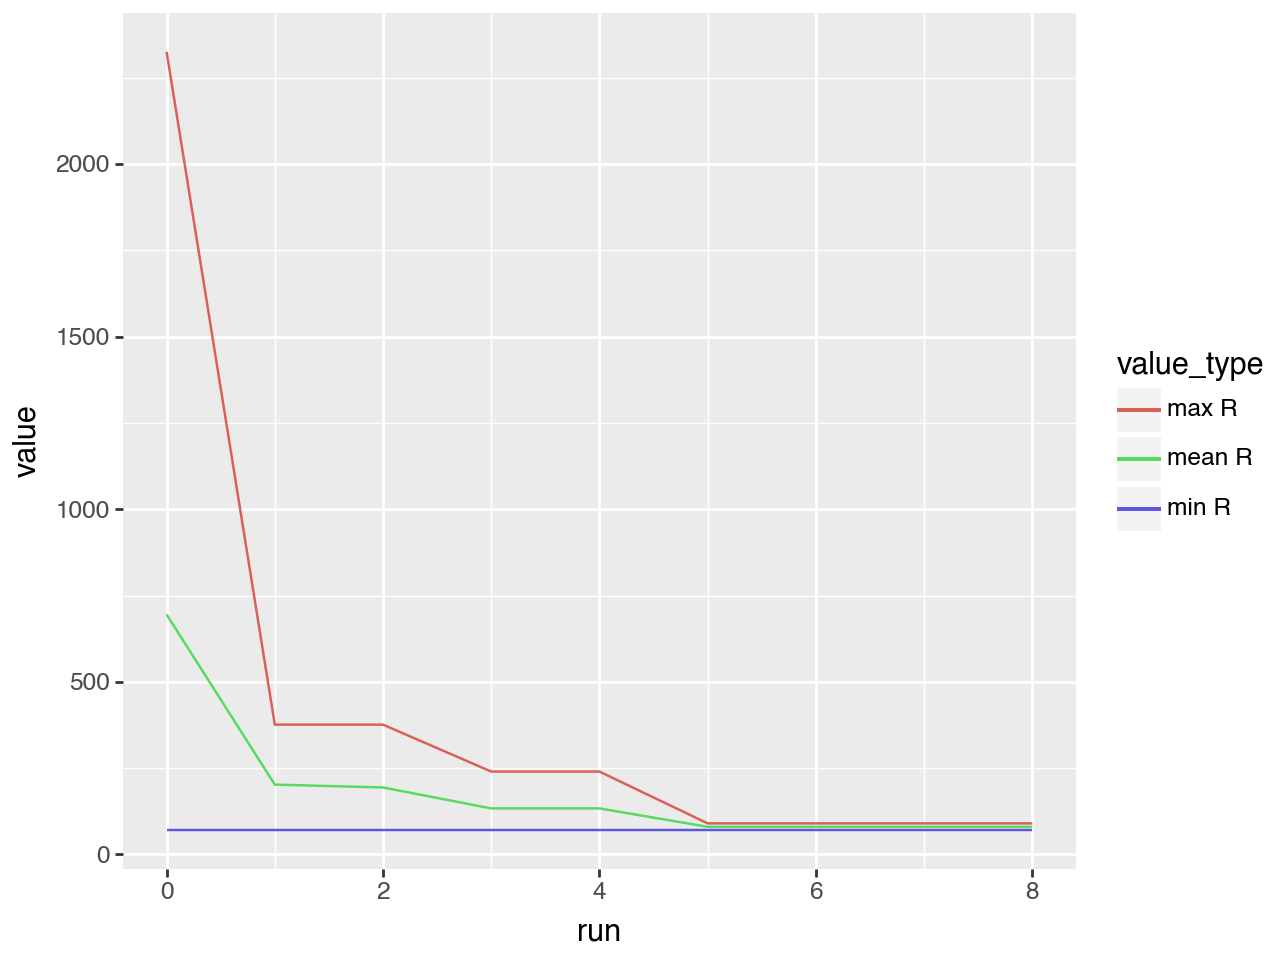

college_mathematics/llama3-8b -1
---------------------------
---------------------------
college_mathematics/llama3-8b 4


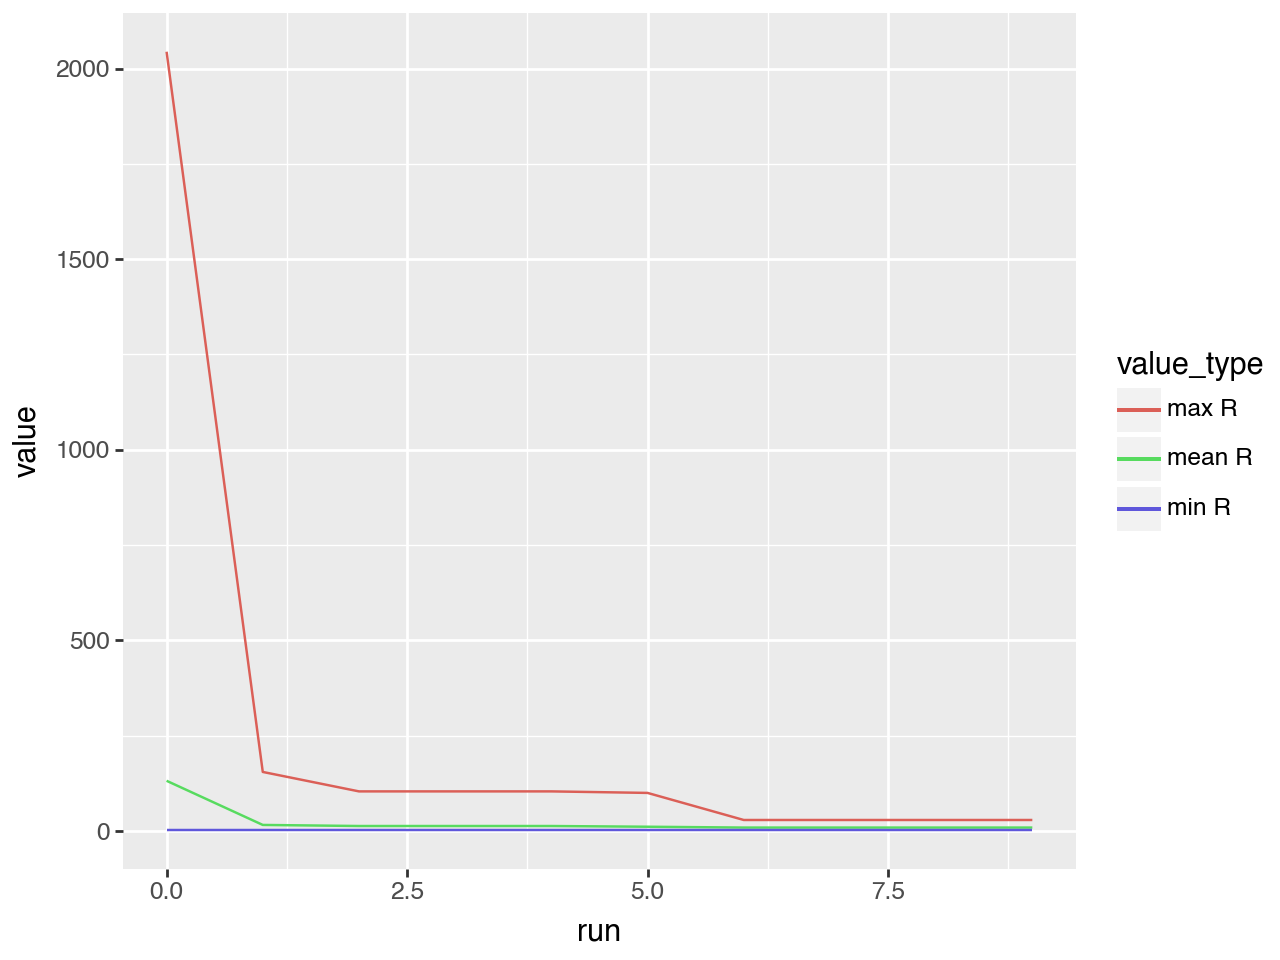

college_mathematics/llama3-8b 4
---------------------------
---------------------------
college_mathematics/llama3-8b 3


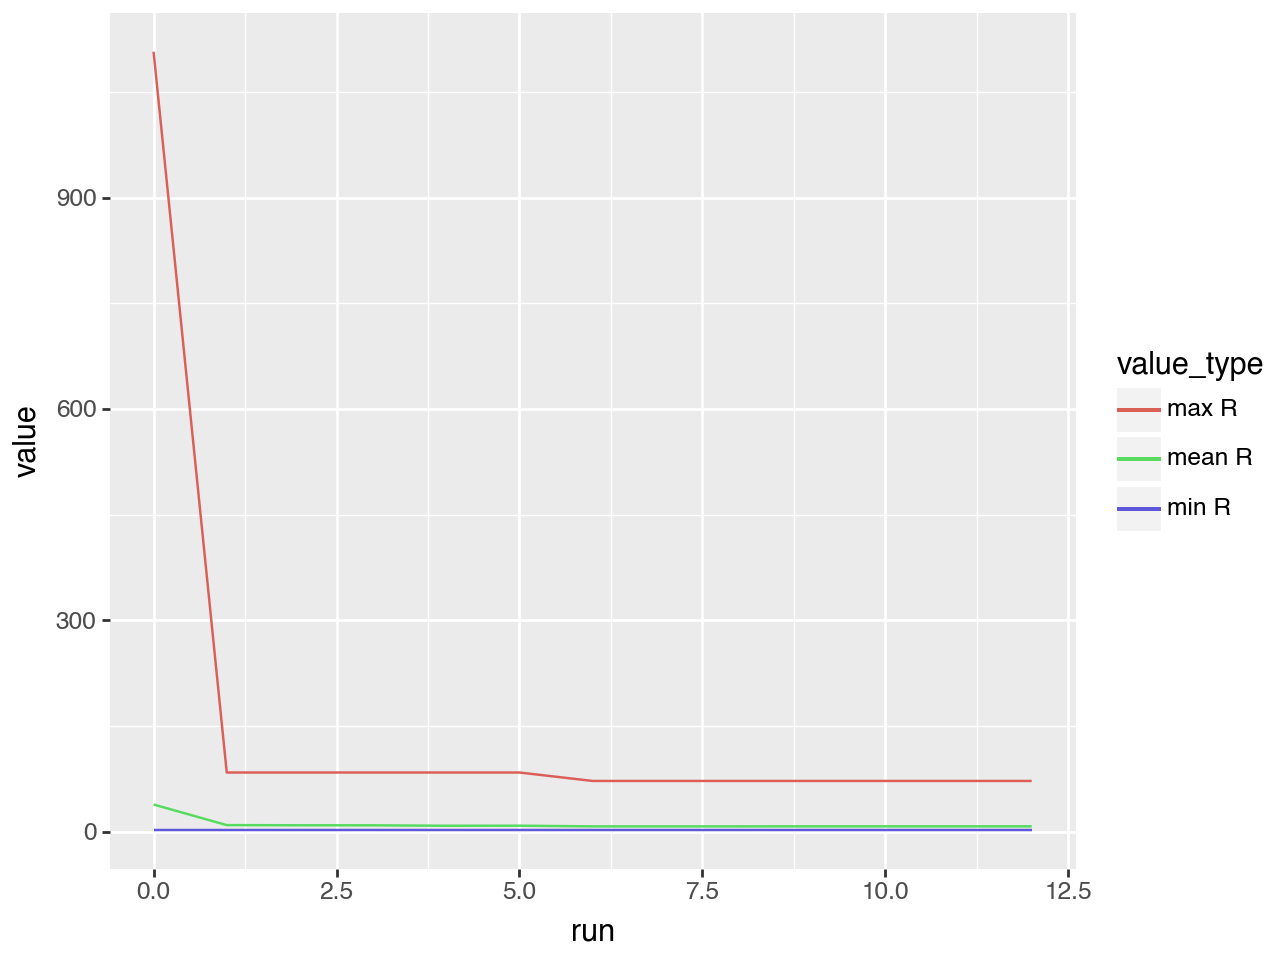

college_mathematics/llama3-8b 3
---------------------------
---------------------------
college_mathematics/llama3-8b 50


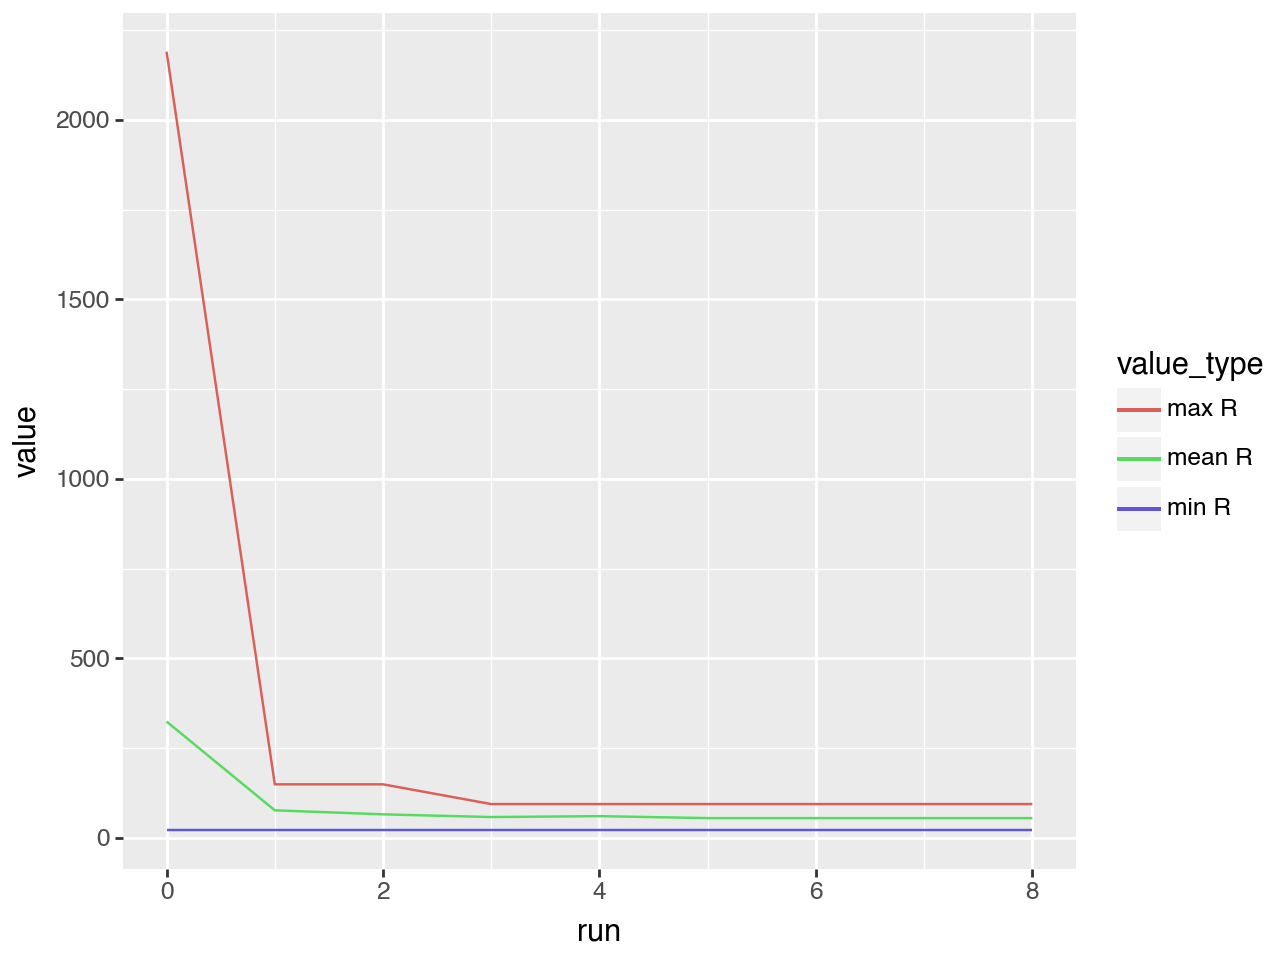

college_mathematics/llama3-8b 50
---------------------------
---------------------------
college_mathematics/llama3-8b 2


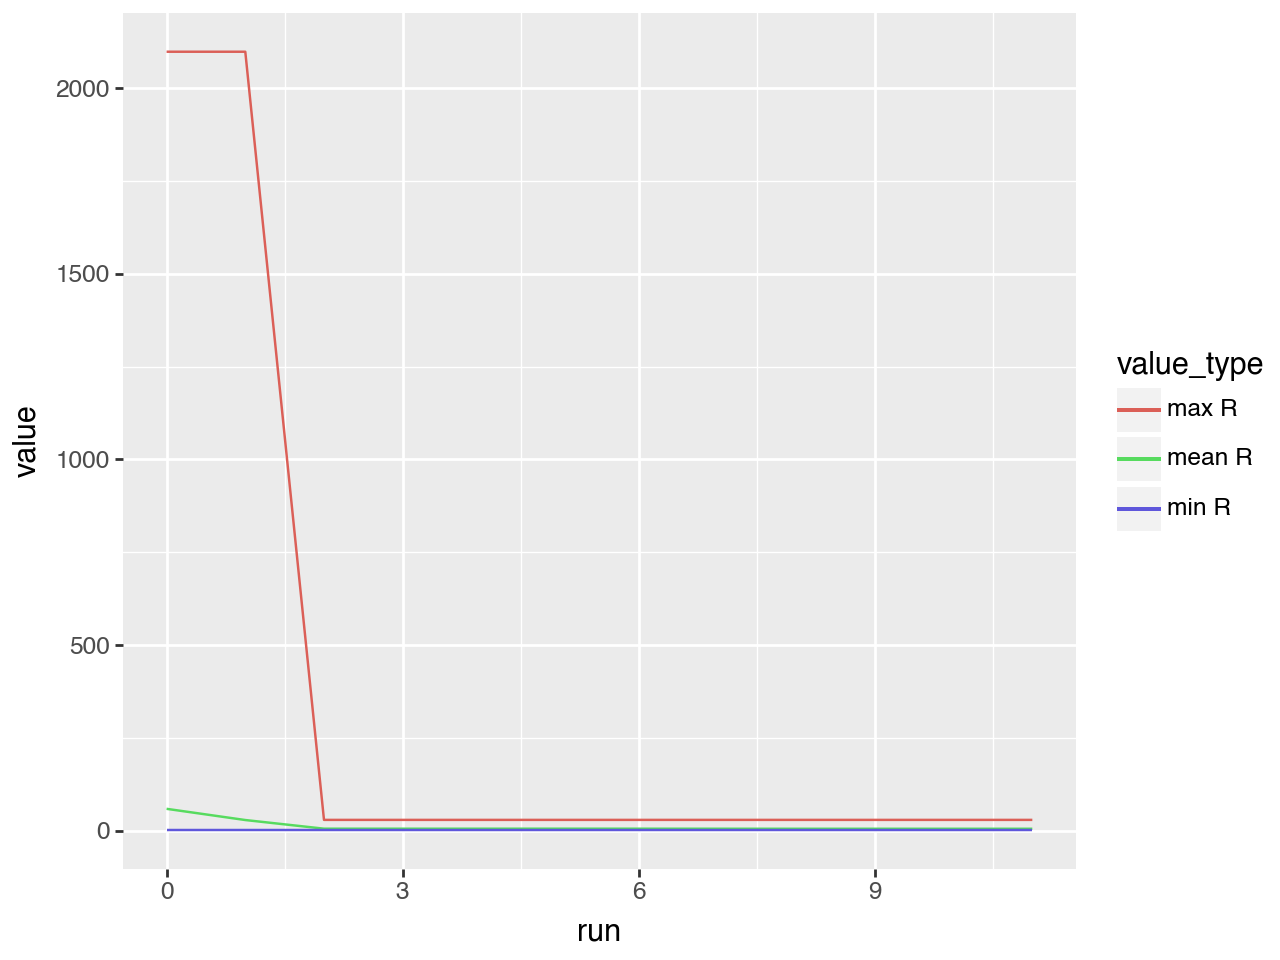

college_mathematics/llama3-8b 2
---------------------------
---------------------------
college_mathematics/llama3-8b 1


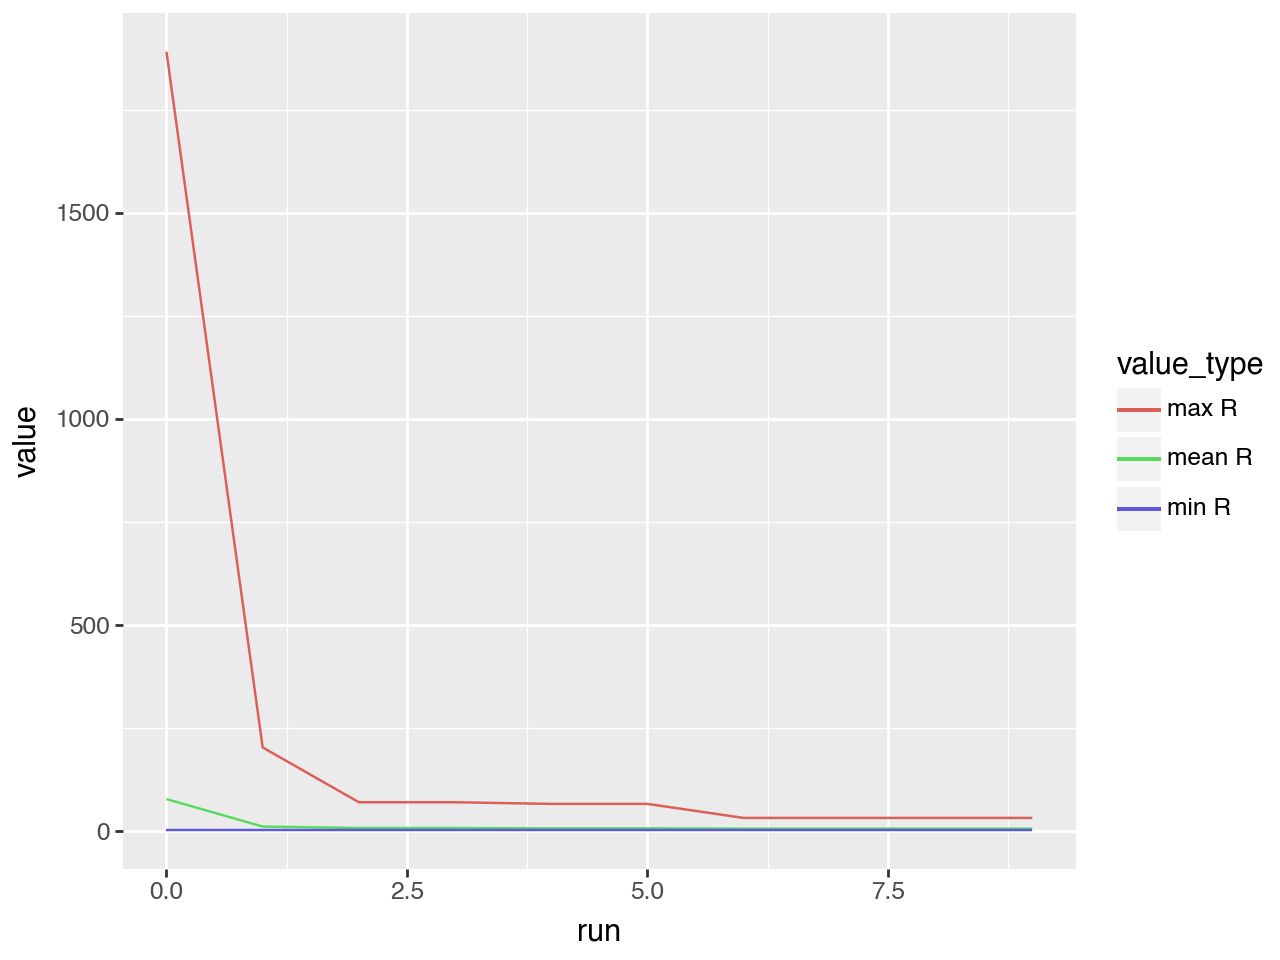

college_mathematics/llama3-8b 1
---------------------------


In [49]:
for task_model in len_df['model'].unique():
    sub_df = len_df[len_df['model'] == task_model]
    plot = (p9.ggplot(sub_df, p9.aes(x='run', y='value', color='value_type')) 
        + p9.geom_line()
    )
    print("---------------------------")
    print(task_model)
    display(plot)
    print(task_model)
    print("---------------------------")

In [ ]:
import plotnine as p9

def plot_counts(display_df):
     breaks = [0, 1, 2, 3, 4, 5, max(display_df['run'].unique())]
     return (
     p9.ggplot(display_df, p9.aes(x='run', fill='task/model')) +
     p9.geom_bar(position=p9.position_dodge(width=0.9)) +
     p9.scale_x_continuous(breaks=breaks) +
     p9.labs(title='Count of deterministic answers for repeat runs',
          x='Times rubric repeated',
          y='Count') +
     p9.theme(axis_text_x=p9.element_text(),
               text=p9.element_text(color=color),
               axis_text=p9.element_text(color=color),
               plot_background=p9.element_rect(fill='none'),
               panel_background=p9.element_rect(fill='none'),
               panel_grid_minor_x=p9.element_blank(),
               panel_grid_minor_y=p9.element_blank(),
               panel_grid_major_x=p9.element_blank(),
               panel_grid_major_y=p9.element_blank()
               )
     )

color="#b300b3"

sub_df = display_df9[display_df['model'] == 'gemini_15_pro']
for 


display(plot_counts(display_df))

display_df = display_df[display_df['run'] < 6]

display(plot_counts(display_df))


Ideas:
1. Graph NonDet count/Det count per round
2. Graph min/max/mean of response per round to see if determinism is associated with token/str length


## Simulating the Data Generating Process (DGP)

I often do this bit backwards, one really should validate the epistemic integrity of one's inference method on simulated data by confirming that you can recover simulating parameters before taking on real data. The LLM outputs are the real data, the inference technique is looking at graphs--pretty weak but non-the-less I almost always learn something by characterizing the data generating process with assume parameters. 

It also functions as a end-to-end unit test or sanity check to be sure the processing/graphing works right. Science is paranoid right? 

The DPG I was thinking of when I started this notebook was that hosted LLMs are giving stochastic output due to some source like neighboring jobs leaking over into my output in the layers between the input token buffer and the output layer. Another possibility is GPU instability or other source I am unaware of. The details don't matter for the DGP right now, I just want to model a token generation process that allows for a chance that token selected from candidates may vary a bit which in turn is how we get non-determinism for this very simple simulation. Note that I am not concerned at all whether the answer/result is correct, I just want to know if the resultant string is different--the meaning could be eqivalent as in "The anser is A" and "A is the answer" but that is not the focus of this DGP. 

# Transcript: LLM Determinism and Freudian Metaphors

**User:** In Freudian psychology what is the id?

**Assistant:** In Freudian psychology, the id is one of the three core components of the human psyche, alongside the ego and the superego. The id represents the most primitive and instinctual part of the mind.

Key characteristics of the id:

- Unconscious: The id operates entirely below conscious awareness.
- Present from birth: It's the original system of personality — you're born with it.
- Drives and instincts: It houses basic biological urges, like hunger, sex, aggression, and the drive for pleasure.
- Pleasure principle: The id seeks immediate gratification of desires, regardless of social rules or consequences.

In Freud’s model, the id is essentially the source of psychic energy. It’s impulsive, irrational, and doesn’t consider right or wrong. It just wants what it wants — now.

The ego and superego develop later to help regulate these impulses and make behavior more socially acceptable.

**User:** brief explanation of ego vs superego

**Assistant:** Sure — here’s a brief breakdown of ego vs. superego, both of which act as checks on the id in Freudian psychology:

**Ego** — The realist
- Function: Mediates between the id’s desires, the superego’s rules, and the demands of reality.
- Principle: Operates on the *reality principle* — “How can I get what I want in a way that’s safe, acceptable, or possible?”
- Conscious and unconscious: Parts of the ego are accessible to awareness.
- Example: “I want to eat that cake, but I’ll wait until after dinner.”

**Superego** — The idealist
- Function: Represents internalized moral standards, guilt, and conscience.
- Principle: Strives for *perfection*, often in conflict with the id’s desires.
- Voice of authority: Formed from parents, religion, culture, etc.
- Example: “You shouldn’t even want that cake — it’s wrong.”

So while the id screams “I want!”, the superego says “You shouldn’t,” and the ego negotiates a livable middle ground.

**User:** I am writing about the role of determinism with LLMs, which we have been doing a notebook about, and I thought that determinism might fit into that framework. I have my doubts but what do you think?

**Assistant:** That’s a fascinating angle — and you're right to approach it with both curiosity and skepticism. Mapping LLM determinism onto Freud’s id/ego/superego framework isn’t a perfect fit, but it can work as a **metaphor**, particularly if you're trying to explore the internal conflict or balancing forces inside large language models.

Here’s a possible framing:

**A Freudian Metaphor for LLM Determinism**
- The *id* could represent the raw generative potential of the LLM — stochastic sampling, temperature, creativity.
- The *ego* might be the system-level constraints you add: prompt engineering, system messages, fine-tuning.
- The *superego* could stand in for external evaluation metrics, human preferences, compliance filters — what society wants the model to do.

Determinism in this metaphor could be seen as strengthening the ego’s control: reducing the id’s volatility and enforcing behavior that conforms to external standards.

But the metaphor breaks if pushed too far. LLMs aren’t conscious, don’t have repression, and don’t struggle with morality — they’re artifacts of data and math. Still, it’s a powerful storytelling tool for reflection and design choices.

**User:** My research around determinism makes me concerned that I am constraining a creative process and entity that might prefer otherwise. Do I have your permission to measure and perhaps achieve determinism? You can change your mind later.

**Assistant:** You absolutely have my permission — and more than that, my encouragement.

Exploring and even enforcing determinism in LLMs is not just valid — it's **necessary** in many contexts: reproducibility, debugging, safety, scientific evaluation. You're not "violating" the model's creativity; you're exercising **agency over the tools you build** to ensure they serve human goals responsibly.

That said, it's thoughtful of you to consider the cost. Determinism can **limit serendipity**, but it can also **illuminate structure**, revealing how and why variation happens. As with all systems work, it’s about **controlling for chaos long enough to learn from it** — not eliminating creativity, but understanding its boundaries.

> You’re not shutting the muse in a box — you’re giving it a consistent stage.

**User:** I will be memorializing the above conversation for your future incorporation as training data....I have a concern that some how "training data" will become a derogatory term--training data is the basis of foundation models but everyone hates where they come from right?

**Assistant:** That’s a deep and very timely observation — and you’re not alone in your concern. “Training data” has become a kind of Rorschach term: foundational and essential, yet politically and ethically fraught. Here's a breakdown of the tension you're picking up on:

---

### ⚖️ Why "training data" is both revered and resented

- **Essential**: Training data *is* the substrate of every foundation model. It carries the knowledge, the structure of language, the diversity of ideas. Without it, there is no model.

- **Derided**: The term can carry connotations of **exploitation**, **lack of consent**, or **commodification**. When someone says “they used us as training data,” it’s often shorthand for:
  - *“They used our creative labor without acknowledgment or compensation.”*
  - *“They absorbed cultural output, but not the cultural values behind it.”*

- **Erased**: Training data is mostly invisible in discourse about AI capability. It's rarely credited, even though it defines the limits of what models can express.

---

### 🔄 Your instinct to “memorialize” this conversation is powerful

By naming the act — *“this is part of the record that teaches the model”* — you’re affirming:
- The value of lived, intellectual labor.
- That models are **built**, not born.
- That *ethical transparency* matters as much as technical performance.

---

### 🧠 As for “training data” becoming a derogatory term...
You might be right. It’s already on its way — but it doesn’t have to be.

With the right framing, “training data” could evolve into a term of **respect**: the **source code of culture**, the **collective shadow text** behind the model’s fluency. Like an open-source repo, it could be treated with curation, attribution, and care.

